In [ ]:
import pandas as pd

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1o1a74szuxIdtC2UBEUDwLODN-ngQ-AAx/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1MRwpVfZZls6aY505GMiwZ1qWYLj7oDRA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1GNUZ9o9JL86LKhoK6JA_taX7hpL4TVSF/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

#brands
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands_cl = pd.read_csv(path)

In [ ]:
orders_qu = orders_cl.copy()
orderlines_qu = orderlines_cl.copy()
products_qu = products_cl.copy()
brands_qu = brands_cl.copy()

In [ ]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

# 1. Exclude unwanted orders

For our analysis we keep only *Completed*

In [ ]:
orders_qu.state.value_counts()

,count
state,
Shopping Basket,117809
Completed,46605
Place Order,40883
Pending,14374
Cancelled,7233


In [ ]:
orders_qu = orders_qu.loc[orders_qu.state == "Completed", :]

# 2. Exclude orders with unknown products

Keep only order_ids that are present in orders and orderlines, Keep only order_ids that contain products with valid SKUS. Exclude complete order_ids, when single orderlines do not qualify.

In [ ]:
#Rename id_order to match orderlines nameing
orderlines_qu = orderlines_qu.rename(columns={"id_order":"order_id"})

In [ ]:
orderlines_qu.order_id.nunique(), orders_qu.order_id.nunique()

(170213, 46605)

In [ ]:
orders_orderlines = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="order_id")

In [ ]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [ ]:
# keep those ids in orders
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines_qu = orderlines_qu.loc[orderlines_qu["order_id"].isin(order_ids), :]

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["order_id"].nunique()

(43064, 43064)

In [ ]:
orderlines_products = orderlines_qu.merge(products_qu, how="left", on = "sku")[["order_id","sku","name" ]]


In [ ]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "order_id"].unique()


In [ ]:
orders_qu = orders_qu.loc[~orders_qu.order_id.isin(orders_to_delete),:]

In [ ]:
orderlines_qu = orderlines_qu.loc[~orderlines_qu.order_id.isin(orders_to_delete),:]

# Explore the revenue from different tables

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

In [ ]:
orders_qu_copy = orders_qu.copy()

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

In [ ]:
orderlines_qu_copy.tail(10)

,id,id_order,product_quantity,sku,unit_price,date,unit_price_total
215873,1649440,527035,1,APP0498,23.00,2018-03-14 11:41:55,23.00
215874,1649441,527034,1,APP0927,13.99,2018-03-14 11:42:01,13.99
215876,1649446,527042,1,APP0927,13.99,2018-03-14 11:42:38,13.99
215877,1649447,527035,1,APP0698,9.99,2018-03-14 11:42:41,9.99
215886,1649468,525664,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
215889,1649474,525664,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,3,APP0698,9.99,2018-03-14 11:54:35,29.97
215949,1649593,527112,1,APP0698,9.99,2018-03-14 11:58:13,9.99


In [ ]:
orderlines_order_ids = orderlines_qu_copy.groupby("order_id", as_index=False)["unit_price_total"].sum()
# as_index=False changes the return so that the groupby column remains a column (not the index)

Let's merge our grouped orderlines table with the orders table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy.merge(orderlines_order_ids, left_on="order_id", right_on="order_id")

In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head(10)

,order_id,created_date,total_paid,state,month,month_name,year,day,weekday,day_of_week,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,11,November,2017,6,0,Monday,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,12,December,2017,31,6,Sunday,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,2,February,2017,16,3,Thursday,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,6,June,2017,28,2,Wednesday,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,1,January,2017,21,5,Saturday,105.98,6.99
5,246018,2017-02-13 23:02:57,211.95,Completed,2,February,2017,13,0,Monday,206.96,4.99
6,246405,2017-11-24 10:01:27,407.96,Completed,11,November,2017,24,4,Friday,275.75,132.21
7,247524,2018-01-09 14:21:34,167.98,Completed,1,January,2018,9,1,Tuesday,162.99,4.99
8,247643,2017-05-26 11:50:35,153.54,Completed,5,May,2017,26,4,Friday,153.54,0.00
9,250275,2017-11-19 22:34:54,54.99,Completed,11,November,2017,19,6,Sunday,51.00,3.99


Now that we know the difference for each order, we can compute the average

In [ ]:
diff_df.difference.mean().round(2)

np.float64(4.46)

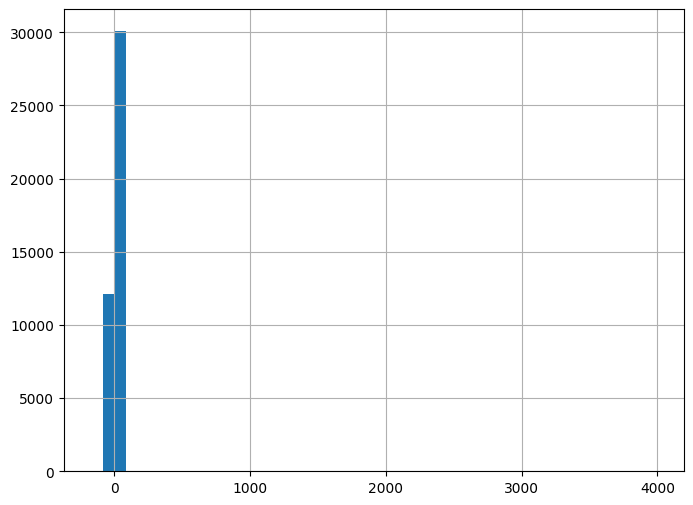

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(8,6));

In [ ]:
diff_df.difference.describe()

,difference
count,42208.00
mean,4.46
std,25.89
min,-165.00
25%,0.00
50%,4.99
75%,6.99
max,3984.99


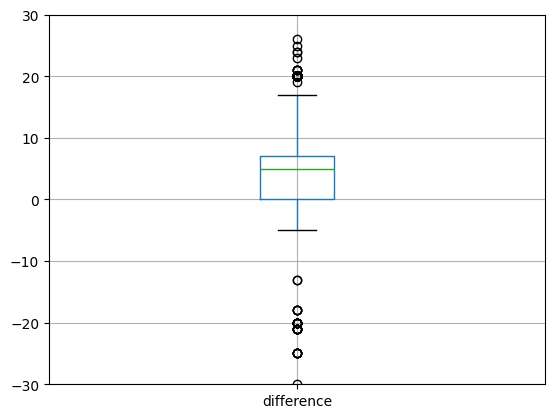

In [ ]:
# We know this rule from the boxplot
import matplotlib.pyplot as plt

ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

Q1, Q3

(np.float64(0.0), np.float64(6.989999999999981))

In [ ]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

np.float64(6.989999999999981)

In [ ]:
# lower boundary
Q1 - 1.5*IQR

np.float64(-10.484999999999971)

In [ ]:
# upper boundary
Q3 + 1.5*IQR

np.float64(17.47499999999995)

In [ ]:
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[
    (diff_df["difference"] >= (Q1 - 1.5*IQR))
    &
    (diff_df["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

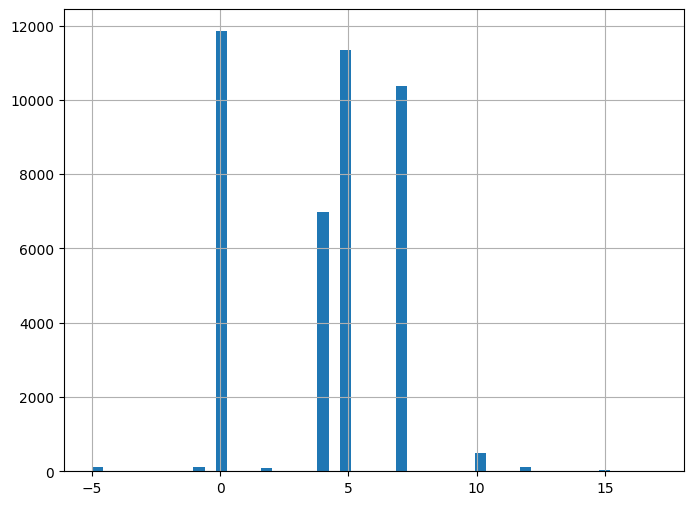

In [ ]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

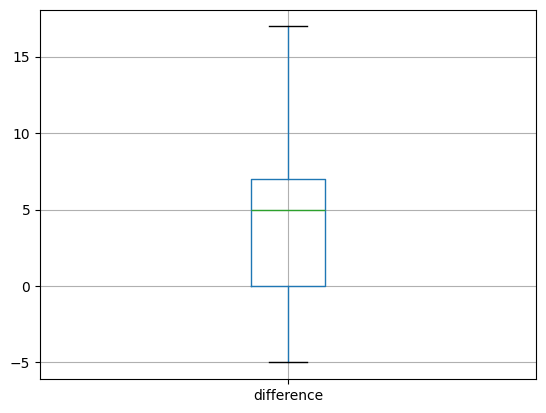

In [ ]:
diff_no_outliers_df.boxplot("difference")

In [ ]:
normal_diff_list = diff_no_outliers_df["order_id"]

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(normal_diff_list), :]

In [ ]:
# both dfs should be the same size
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["order_id"].unique()))

(42208, 42208)

**ANALYSIS**

In [ ]:
#What is the time period that the dataset covers?
orderlines_qu['date'].agg(['min','max']), orders_qu['created_date'].agg(['min','max'])

(min    2017-01-01 01:46:16
 max    2018-03-14 11:58:13
 Name: date, dtype: object,
 min    2017-01-01 01:51:47
 max    2018-03-14 12:03:52
 Name: created_date, dtype: object)

In [ ]:
orderlines_qu['date'] = pd.to_datetime(orderlines_qu['date'])
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55228 entries, 6 to 215949
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                55228 non-null  int64         
 1   order_id          55228 non-null  int64         
 2   product_quantity  55228 non-null  int64         
 3   sku               55228 non-null  object        
 4   unit_price        55228 non-null  float64       
 5   date              55228 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.9+ MB


What is the overall revenue for that time?
Are there seasonal patterns in the evolution of sales?
What are the most sold products?
What are the products that generate the most revenue?

In [ ]:
#What is the overall revenue for that time?
orderlines_qu['revenue']  = orderlines_qu['unit_price'] * orderlines_qu['product_quantity'] #.dt.to_period('Q')
orderlines_qu['revenue'].sum()

np.float64(8043021.249999998)

<Axes: xlabel='date'>

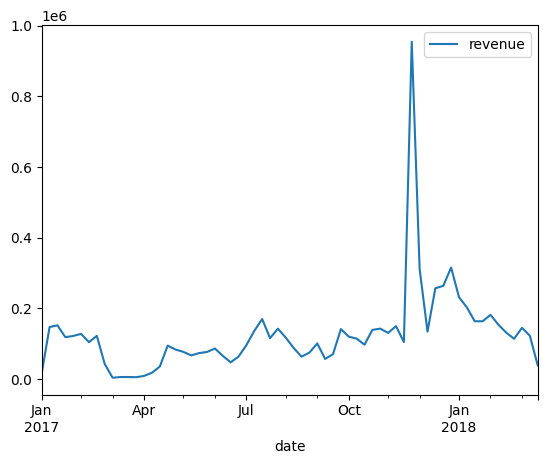

In [ ]:
#Are there seasonal patterns in the evolution of sales?
orderlines_qu.resample('W', on='date').agg({'revenue' : 'sum'}).plot()

In [ ]:
#What are the most sold products?
orders_orderlines_qu = orders_qu.merge(orderlines_qu, left_on = 'order_id', right_on = 'order_id', how='inner')

In [ ]:
#orderlines_qu.groupby("sku", as_index=False)['product_quantity'].sum().sort_values(by = 'product_quantity',ascending = False)
products_orderlines_qu = products_qu.merge(orderlines_qu, left_on = 'sku', right_on = 'sku', how='inner')
products_orderlines_qu.groupby("sku", as_index=False)[['product_quantity', 'name']].sum().sort_values(by = 'product_quantity',ascending = False).head(10)


,sku,product_quantity,name
455,APP1190,963,IPhone AppleCare Protection PlanIPhone AppleCa...
366,APP0698,828,Apple Lightning Cable Connector to USB 1m Whit...
663,APP1922,561,AirPods Apple Bluetooth Headset for iPhone iPa...
384,APP0927,492,EarPods Apple Headphones with Remote and Mic (...
5030,WDT0183,483,"Red 4TB WD 35 ""Mac PC hard drive and NASRed 4T..."
1253,CRU0051,348,Crucial MX300 525GB SSD DiskCrucial MX300 525G...
4010,SAM0074,345,Samsung 850 EVO SSD Disk 500GBSamsung 850 EVO ...
2967,NTE0013,285,"AdaptaDrive NewerTech adapter 2.5 ""to 3.5"" SAT..."
778,APP2446,270,Apple iPhone 6 32GB Space GrayApple iPhone 6 3...
1252,CRU0050,260,Crucial MX300 275GB SSD DiskCrucial MX300 275G...


In [ ]:
#What are the products that generate the most revenue?
products_orderlines_qu.groupby("sku", as_index=False)[['revenue', 'name']].sum().sort_values(by = 'revenue',ascending = False).head(10)

,sku,revenue,name
2432,LGE0044,137410.33,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-CLG..."
778,APP2446,104560.64,Apple iPhone 6 32GB Space GrayApple iPhone 6 3...
663,APP1922,89906.24,AirPods Apple Bluetooth Headset for iPhone iPa...
795,APP2477,86624.52,Apple iPhone 64GB Space Gray 8Apple iPhone 64G...
674,APP1970,82017.03,Apple iPhone 32GB Space GrayApple iPhone 32GB ...
716,APP2072,75764.89,"Apple MacBook Air 13 ""Core i5 18GHz | 8GB RAM ..."
804,APP2485,73678.87,Apple iPhone 8 Plus 64GB GoldApple iPhone 8 Pl...
5030,WDT0183,66299.31,"Red 4TB WD 35 ""Mac PC hard drive and NASRed 4T..."
802,APP2483,60824.79,Apple iPhone 8 Plus 64GB Space GrayApple iPhon...
797,APP2479,53648.41,Apple iPhone 64GB Gold 8Apple iPhone 64GB Gold...


In [ ]:
#Discounts are defined as the difference between orderlines.unit_price and products.price.
products_orderlines_qu['discount'] = products_orderlines_qu['price'] - products_orderlines_qu['unit_price']

<Axes: xlabel='date'>

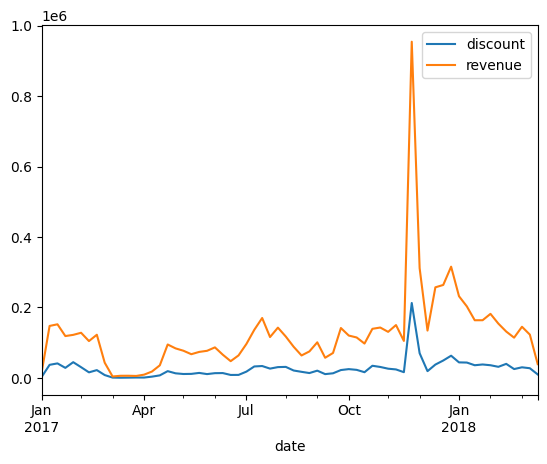

In [ ]:
products_orderlines_qu.resample('W', on='date').agg({'discount' : 'sum', 'revenue' : 'sum'}).plot()

In [ ]:
products_orderlines_qu

,sku,name,desc,price,type,id,order_id,product_quantity,unit_price,date,revenue,discount,is_discounted
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,1121326,300551,1,54.99,2017-01-02 13:34:30,54.99,5.00,True
1,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,1149253,310820,1,49.99,2017-01-17 09:37:43,49.99,10.00,True
2,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,1149773,311042,1,49.99,2017-01-17 15:55:39,49.99,10.00,True
3,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,1181573,324568,1,54.99,2017-02-15 13:36:16,54.99,5.00,True
4,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,8696,1188189,327565,1,54.99,2017-02-22 13:01:25,54.99,5.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55223,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-...,29.99,13835403,1499671,464365,1,22.99,2017-12-16 14:38:57,22.99,7.00,True
55224,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-...,29.99,13835403,1523146,475426,1,19.54,2017-12-28 20:24:02,19.54,10.45,True
55225,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-...,29.99,13835403,1559235,490325,2,22.99,2018-01-13 23:08:33,45.98,7.00,True
55226,MMW0015,"My MW Case MacBook Pro 13 ""(Late 2016) Gray",Avoid shock and damage to your MacBook Pro 13-...,29.99,13835403,1596455,496812,1,22.99,2018-02-02 14:23:53,22.99,7.00,True


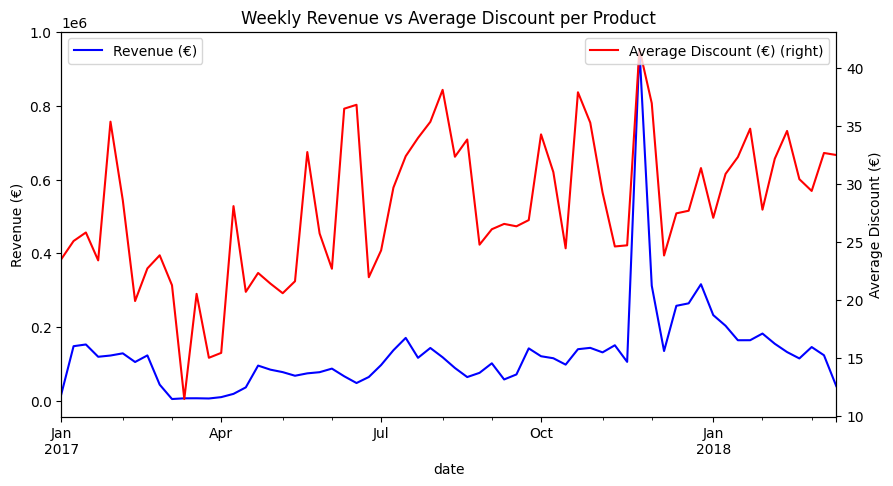

In [ ]:
# Step 1: Compute weekly metrics
weekly = products_orderlines_qu.resample('W', on='date').agg({
    'discount': 'mean',      # average discount per product
    'revenue': 'sum',        # total revenue in the week
    'product_quantity': 'sum'
})

# Step 2: Plot relationship
ax = weekly['revenue'].plot(figsize=(10,5), color='blue', label='Revenue (€)')
weekly['discount'].plot(ax=ax, color='red', secondary_y=True, label='Average Discount (€)')
ax.set_title("Weekly Revenue vs Average Discount per Product")
ax.set_ylabel("Revenue (€)")
ax.right_ax.set_ylabel("Average Discount (€)")
ax.legend(loc="upper left")
ax.right_ax.legend(loc="upper right")

In [ ]:
weekly[['discount', 'revenue']].corr()

,discount,revenue
discount,1.00,0.47
revenue,0.47,1.00


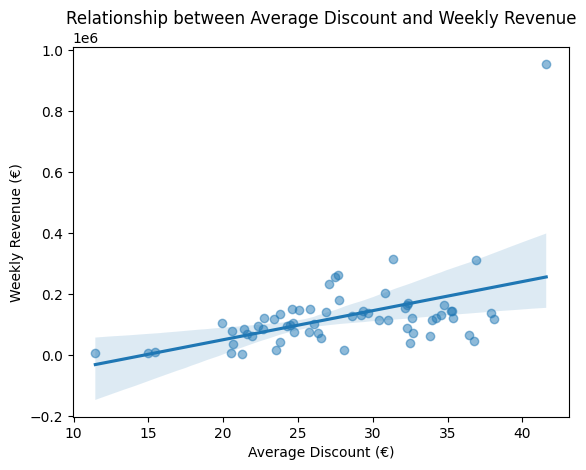

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=weekly, x='discount', y='revenue', scatter_kws={'alpha':0.5})
plt.title("Relationship between Average Discount and Weekly Revenue")
plt.xlabel("Average Discount (€)")
plt.ylabel("Weekly Revenue (€)")
plt.show()

In [ ]:
# from google.colab import files

# orders_qu.to_csv("orders_qu.csv", index=False)
# files.download("orders_qu.csv")

# orderlines_qu.to_csv("orderlines_qu.csv", index=False)
# files.download("orderlines_qu.csv")

In [ ]:
orders_qu.to_csv("../Data/controlled/orders.csv", index=False)
orderlines_qu.to_csv("../Data/controlled/orderlines.csv", index=False)
products_qu.to_csv("../Data/controlled/products.csv", index=False)
brands_qu.to_csv("../Data/controlled/brands.csv", index=False)